In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

### Loading Clean Data

In [3]:
clean=pd.read_csv("Bitcoin_clean.csv") #Se extraen los datos
df=pd.DataFrame(clean)

### Selecting which data to use

In [5]:
df = df[2106884:2206884]
df.reset_index(drop=True,inplace=True)

In [35]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(training_data,columns=df.columns)
df_scaled

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,0.00000,0.556979,0.555712,0.556910,0.556643,0.002875,0.002779,0.556818
1,0.00001,0.556640,0.555373,0.555766,0.555747,0.002407,0.002326,0.556278
2,0.00002,0.554502,0.554474,0.556211,0.555745,0.000831,0.000802,0.555898
3,0.00003,0.554165,0.554474,0.555656,0.555334,0.001089,0.001052,0.555318
4,0.00004,0.554989,0.553717,0.554774,0.554121,0.000998,0.000964,0.554732
...,...,...,...,...,...,...,...,...
99995,0.99996,0.061514,0.060858,0.063195,0.063534,0.003526,0.002544,0.063971
99996,0.99997,0.063530,0.060856,0.063195,0.061516,0.000150,0.000108,0.064399
99997,0.99998,0.063496,0.060822,0.065162,0.063484,0.000082,0.000059,0.064617
99998,0.99999,0.063441,0.060766,0.063223,0.061545,0.000433,0.000313,0.064258


In [53]:
# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(df.shape[0]*.8)-1

# Split into train and test sets but keep all columns
train_pre_x = df_scaled.iloc[:n_train_rows, :]
test_pre_x = df_scaled.iloc[n_train_rows:, :]
train_pre_y = df.iloc[:n_train_rows, [1,4]]
test_pre_y = df.iloc[n_train_rows:, [1,4]]

# The total rows of the two datasets should equal the total amount of rows in your CSV
print(train.shape)
print(test.shape)

(79999, 8)
(20001, 8)


### Transforming 'y' data

In [63]:
transformer_y = MinMaxScaler().fit(train_pre_y)
y_train_scaled = transformer_y.transform(train_pre_y)
y_test_scaled = transformer_y.transform(test_pre_y) 

### Creating final train and test

In [79]:
blocks=50
x_train = []
x_test = []
y_train = []
y_test = []

for i in range(blocks, train_pre_x.shape[0]-blocks):
    
    x_train.append(train_pre_x.to_numpy()[i-blocks:i,:])
    y_train.append(y_train_scaled[i,:])
                   
for i in range(blocks, test_pre_x.shape[0]-blocks):
                   
    x_test.append(test_pre_x.to_numpy()[i-blocks:i,:])
    y_test.append(y_test_scaled[i,:])
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

print(x_train.shape)
print(x_test.shape)

(79899, 50, 8)
(19901, 50, 8)


In [85]:
y_test.shape

(19901, 2)

In [97]:
model = Sequential()
model.add(LSTM(16, input_shape=(x_train.shape[1],x_train.shape[2]))) # Input Layer
model.add(Dropout(0.1))
model.add(Dense(2))                    # Output Layer

In [98]:
model.summary()
model.compile(loss='mean_squared_error',optimizer=RMSprop())
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    validation_data = (x_test, y_test),
                    shuffle=False)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 16)                1600      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,634
Trainable params: 1,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1249/1249 [==============================] - 9s 7ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 2/5
1249/1249 [==============================] - 8s 6ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3/5
1249/1249 [==============================] - 8s 7ms/step - loss: 7.5811e-04 - val_loss: 0.0014
Epoch 4/5

Score=  0.0011155861429870129


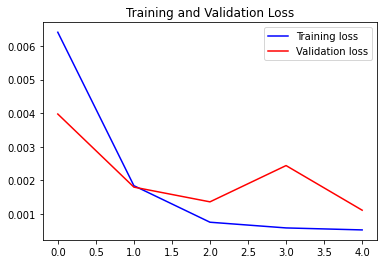

In [99]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Score= ', str(score))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

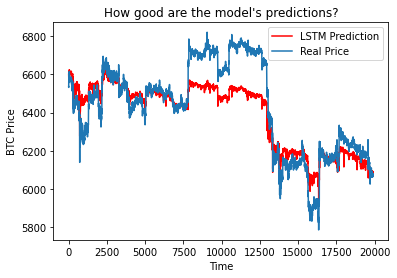

In [116]:
pd.DataFrame(transformer_y.inverse_transform(model.predict(x_test)), columns=['Open','Volume'])['Open'].plot(color='r',label='LSTM Prediction')
pd.DataFrame(transformer_y.inverse_transform(y_test), columns=['Open','Volume'])['Open'].plot(label='Real Price')
plt.title("How good are the model's predictions?")
plt.legend()
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.show()